# Stock Forecasting using Darts

https://github.com/unit8co/darts

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

In [2]:
stock = '^GSPC' # input
start = '2018-01-01' # input 
end = '2022-07-21'  # input
df = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3367250000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3538660000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3695260000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3236620000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3242650000


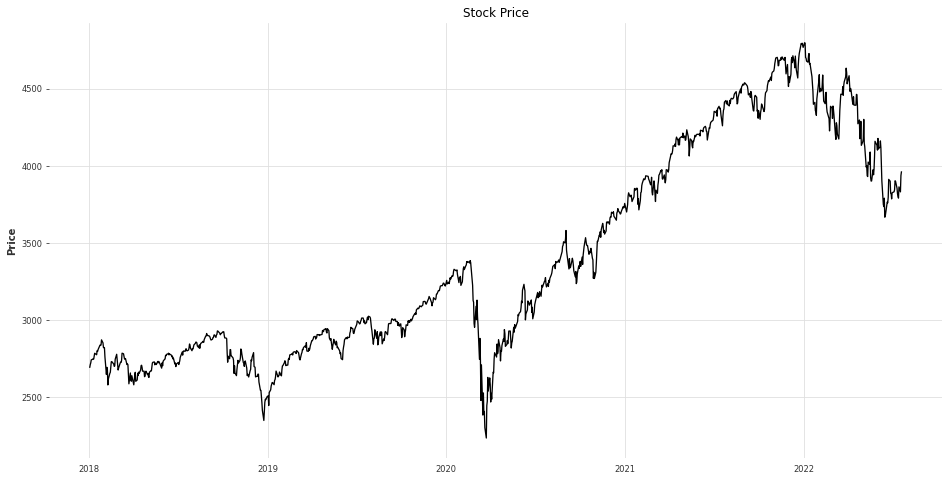

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.title('Stock Price')
plt.ylabel('Price')
plt.show()

In [5]:
scaler_close = Scaler()

In [6]:
dfm = df.resample('M').mean()

In [7]:
dfm = dfm.reset_index()

In [8]:
series = TimeSeries.from_dataframe(dfm, 'Date', 'Adj Close')

In [9]:
series

<TimeSeries (DataArray) (Date: 55, component: 1, sample: 1)>
array([[[2789.80381557]],

       [[2705.15524774]],

       [[2702.77382115]],

       [[2653.62520926]],

       [[2701.49361905]],

       [[2754.35288783]],

       [[2793.64335705]],

       [[2857.82042926]],

       [[2901.50051398]],

       [[2785.46478006]],

...

       [[4460.70707775]],

       [[4667.386649  ]],

       [[4674.77277166]],

       [[4573.8154541 ]],

       [[4435.98049445]],

       [[4391.2652641 ]],

       [[4391.29599609]],

       [[4040.36000279]],

       [[3898.94668434]],

       [[3858.44536884]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2018-01-31 2018-02-28 ... 2022-07-31
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

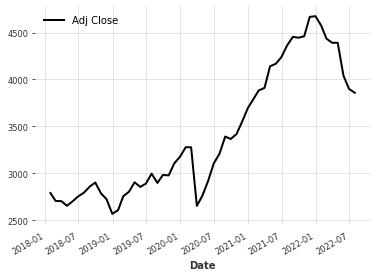

In [10]:
series.plot()

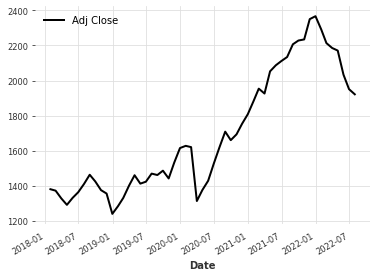

In [11]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

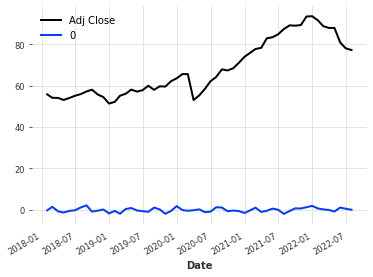

In [12]:
(series / 50).stack(series_noise).plot()

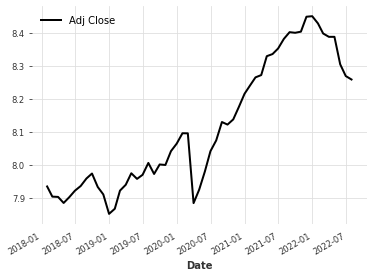

In [13]:
series.map(np.log).plot()

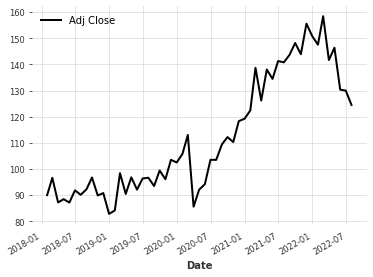

In [14]:
series.map(lambda ts, x: x / ts.days_in_month).plot()

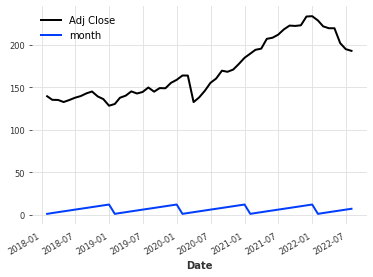

In [15]:
(series / 20).add_datetime_attribute("month").plot()

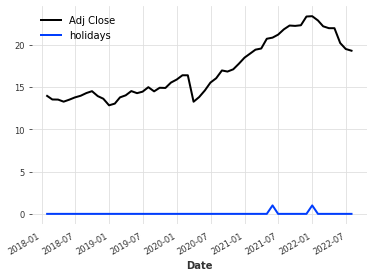

In [16]:
(series / 200).add_holidays("US").plot()

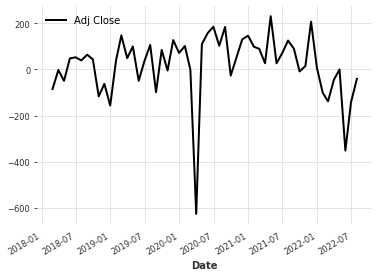

In [17]:
series.diff().plot()

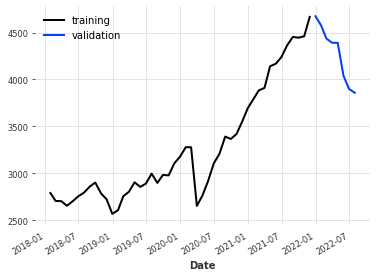

In [18]:
train, val = series.split_before(pd.Timestamp("20220101"))
train.plot(label="training")
val.plot(label="validation")

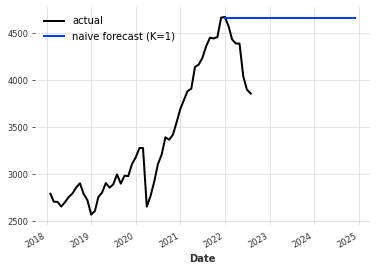

In [19]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [20]:
train

<TimeSeries (DataArray) (Date: 47, component: 1, sample: 1)>
array([[[2789.80381557]],

       [[2705.15524774]],

       [[2702.77382115]],

       [[2653.62520926]],

       [[2701.49361905]],

       [[2754.35288783]],

       [[2793.64335705]],

       [[2857.82042926]],

       [[2901.50051398]],

       [[2785.46478006]],

...

       [[3883.43211606]],

       [[3910.50827955]],

       [[4141.17619978]],

       [[4167.84953613]],

       [[4238.48954634]],

       [[4363.71279762]],

       [[4453.96593129]],

       [[4445.54331752]],

       [[4460.70707775]],

       [[4667.386649  ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2018-01-31 2018-02-28 ... 2021-11-30
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

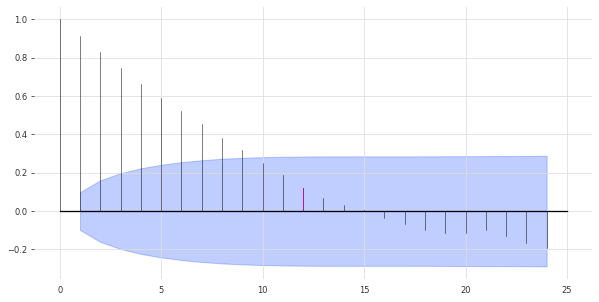

In [21]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.5)

In [22]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [23]:
print("There is seasonality of order {}.".format(period))

There is seasonality of order 24.


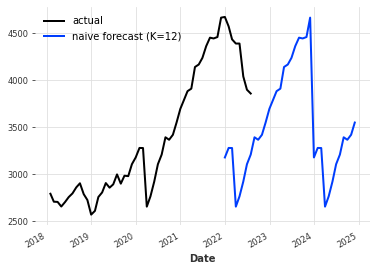

In [24]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

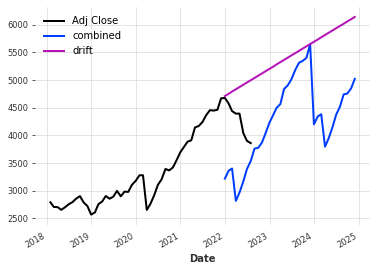

In [25]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [26]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 24.07%.


In [27]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 12.92%
model (T)BATS obtains MAPE: 10.20%
model Auto-ARIMA obtains MAPE: 13.94%
model Theta(2) obtains MAPE: 11.65%


In [28]:
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [29]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 6.44, with theta = 0.5714285714285712.


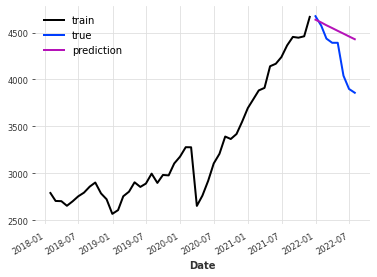

In [30]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

  0%|          | 0/21 [00:00<?, ?it/s]

MAPE = 10.59%


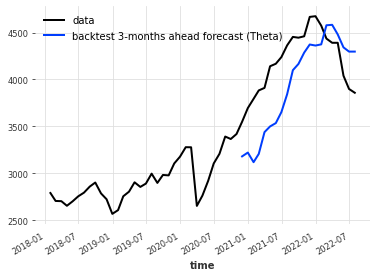

In [31]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/21 [00:00<?, ?it/s]

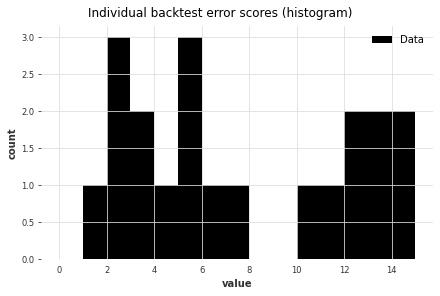

In [32]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [33]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/21 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 8.00


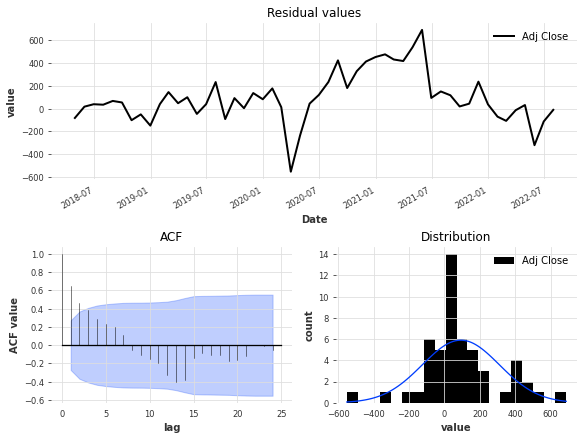

In [34]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

  0%|          | 0/21 [00:00<?, ?it/s]

MAPE = 6.70%


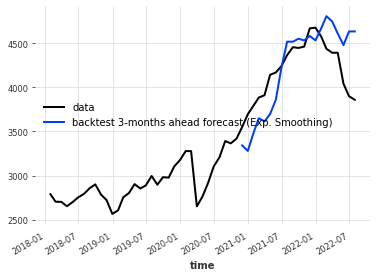

In [35]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

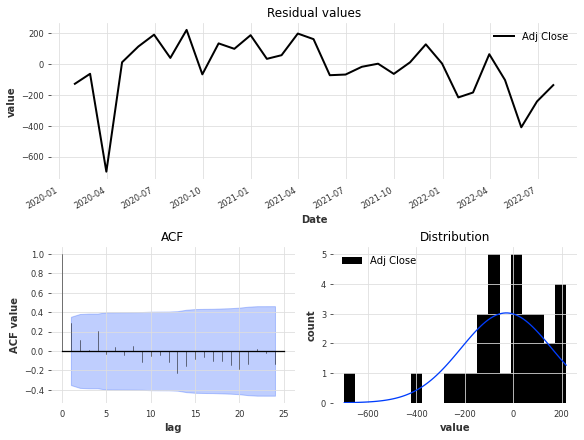

In [36]:
plot_residuals_analysis(model_es.residuals(series))